# カーネルPCA (KPCA)

## ライブラリーのインポート

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.decomposition import KernelPCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## データセットのインポート

In [206]:
# データセットをロード
X,y = datasets.make_circles(n_samples=2000, random_state=1, noise=0.2, factor=0.2)

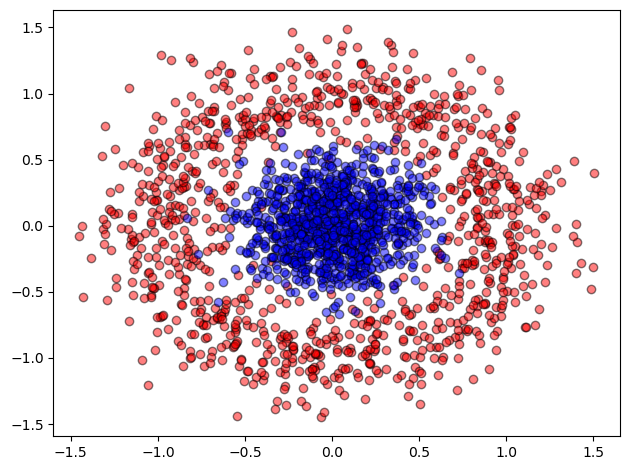

In [207]:
# データセットの確認
plt.scatter(x=X[y == 0, 0], 
            y=X[y == 0, 1],
                   alpha=0.5, 
                   color='red',
                   marker='o', 
                   label="label 0", 
                   edgecolor='black')
plt.scatter(x=X[y == 1, 0], 
            y=X[y == 1, 1],
                   alpha=0.5, 
                   color='blue',
                   marker='o', 
                   label="label 1", 
                   edgecolor='black')
plt.tight_layout()
plt.show()

## 訓練データ、テストデータに分割

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 特徴量のスケーリング

In [309]:
sc = StandardScaler()
# 平均と標準偏差を用いて標準化
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## KPCAの適用

In [310]:
# 前ステップの線形判別のグラフより次元数を指定して、LDAのインスタンスを生成
kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma=1)
# 次元削減
X_train = kpca.fit_transform(X_train, y_train)
X_test = kpca.transform(X_test)

## 訓練データによるモデルの学習

In [311]:
# ロジスティック回帰のインスタンスを作成
classifier = LogisticRegression(C=100, random_state=0, solver='lbfgs', multi_class='ovr')
# 訓練データをモデルに適合させる
classifier.fit(X_train, y_train)

LogisticRegression(C=100, multi_class='ovr', random_state=0)

## 新しいデータポイントでの予測

In [312]:
#新しいデータの特徴量
new_data = [[14,1,]] 
pred_label = classifier.predict(kpca.transform(sc.transform(new_data)))[0]
print(f'予測したクラス:{pred_label}')

予測したクラス:0


## テストデータで予測

In [313]:
# テストデータで予測を実施
y_pred = classifier.predict(X_test)

## モデルの性能評価

In [314]:
# 正分類のデータ点の個数を表示
print(f'正分類のデータ点: {(y_test == y_pred).sum()}個/{len(y_test)}個' )

# 分類の正解率を表示
print(f'Accuracy(Test): {accuracy_score(y_test, y_pred):.3f}')

正分類のデータ点: 387個/400個
Accuracy(Test): 0.968


## 性能評価の可視化

In [315]:
# 訓練データとテストデータの最小値と最大値を計算
def calculate_bounds(X1, X2):
    X1_min, X1_max = X1.min() - (X1.max()-X1.min())/20, X1.max() + (X1.max()-X1.min())/20
    X2_min, X2_max = X2.min() - (X2.max()-X2.min())/20, X2.max() + (X2.max()-X2.min())/20
    return X1_min, X1_max, X2_min, X2_max

In [316]:
def plot_data(ax, X_set, y_set, X1, X2, Z, colors, kind, classifier):
    cmap = ListedColormap(colors[:len(np.unique(y_set))])
    ax.contourf(X1, X2, Z, alpha=0.3, cmap=cmap)
    for idx, feature in enumerate(np.unique(y_set)):
        ax.scatter(x=X_set[y_set == feature, 0], 
                   y=X_set[y_set == feature, 1],
                   alpha=0.5, 
                   color=colors[idx],
                   marker='o', 
                   label=f'label {feature}', 
                   edgecolor='black')
    ax.set_xlabel('KPCA1')
    ax.set_ylabel('KPCA2')
    ax.set_title(f'{type(classifier).__name__}_KPCA({kind})')
    ax.legend(loc='best')

In [317]:
def plot_decision_regions(X_train, X_test, y_train, y_test, classifier):
    # マーカーとカラーマップの準備
    colors = ('red', 'blue', 'green')
    
    # スケーリング前の元のデータに変換
    X_train_set, y_train_set = X_train, y_train
    X_test_set, y_test_set = X_test, y_test
    
    # 訓練データとテストデータの範囲を統一
    X_combined = np.vstack((X_train_set, X_test_set))
    X1_min, X1_max, X2_min, X2_max = calculate_bounds(X_combined[:, 0], X_combined[:, 1])
    
    # グリッドポイントの生成
    X1, X2 = np.meshgrid(np.arange(X1_min, X1_max, step=(X1_max - X1_min) / 1000),
                         np.arange(X2_min, X2_max, step=(X2_max - X2_min) / 1000))
    # 各特徴を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(X1.shape)
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    # 訓練データとテストデータのプロット
    plot_data(ax[0], X_train_set, y_train_set, X1, X2, Z, colors, "Training set", classifier)
    plot_data(ax[1], X_test_set, y_test_set, X1, X2, Z, colors, "Test set", classifier)
    
    plt.tight_layout()
    plt.show()

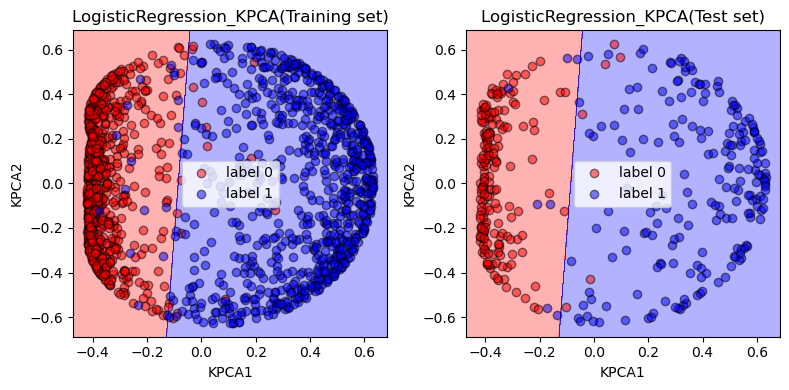

In [318]:
# 決定境界のプロット
if kpca.n_components == 2:
    plot_decision_regions(X_train, X_test, y_train, y_test, classifier)